In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import pandas as pd
import math
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
from sklearn.neighbors import kneighbors_graph
import time

import scipy.sparse as sparse
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

#nicer plots
import seaborn


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
def numerical_diff(x_list, y_list):
    index_sorted = np.argsort(x_list)
    invert_index_sort = np.argsort(index_sorted)
    y_grad = np.gradient(y_list[index_sorted], np.gradient(x_list[index_sorted]))[invert_index_sort]
    return y_grad

x = np.random.rand(1000)
y = np.sin(30*x)
y_grad = numerical_diff(x, y)

plt.plot(x, y_grad, "bo")

In [156]:
class BSDE(object):
    
    def __init__(self,S0, K, T, mu, sigma, q):
        ''' 
        
        Parameters
        ==========
        S0             : float
                          positive, initial Stock Value
        mu              : float
                          drift
        K               : float 
                          Strike price
        T               : float 
                          Maturity time 
        sigma           : float 
                          volatility
         Returns
        =======
        BSDE : class
        '''
        self.S0 = S0 
        self.K = K 
        self.T = T
        self.mu = mu
        self.sigma = sigma 
        self.q = q

    def generate_paths(self,r,N,m, mode='delta_B'):
        if mode == 'delta_B':
            dt = self.T / m
            S = np.zeros((m + 1, N))
            dB = np.zeros((m + 1, N))
            S[0] = self.S0
            for t in range(1,m + 1):
                X = np.random.standard_normal(size=N)
                S[t] = S[t - 1] * np.exp((self.mu - self.sigma * self.sigma/2) * dt
                                         + self.sigma * np.sqrt(dt) * X)
                dB[t] =  np.sqrt(dt) * X
            return (S, dB)
        elif mode=='B':
            dt = self.T / m
            S = np.zeros((m + 1, N))
            B = np.zeros((m + 1, N))
            S[0] = self.S0
            for t in range(1, m + 1):
                X = np.random.standard_normal(size=N)
                S[t] = S[t - 1] * np.exp((self.mu - self.sigma * self.sigma / 2) * dt
                                         + self.sigma * np.sqrt(dt) * X)
                B[t] = np.sqrt(t) * X
            return (S, B)


    def get_price_lsm(self, R, r, N, m, 
                      K1 = 95., K2 = 105., deg=8, 
                      oPayoff = "call", oType = "European", n_picard = 10):
        '''
        Function to generate stock paths.

        Parameters
        ==========
 
        r               : float 
                          lending interest rate 
        R               : float 
                          borrowing interest rate 
        N               : int 
                          Number of paths generated      
        m               : int 
                          number of steps
        d               : int 
                          polynomial fit degree

        Returns
        =======
        Y_opt : float
                Price of the European option
                
        Remarks
        =======
        equivalent to solving the BSDE:
            -dY = driver * dt - Z * dW
        where:
            driver = [(r-mu)/sigma]*Z - r*Y + (R-r)*(Y-Z/sigma)^-
        '''  
        #Time-step
        dt = self.T / m     
        #Discount factor
        df = 1. / (1 + r * dt)
        theta = -(r - self.mu) / self.sigma
        # S, dB
        S, dB = self.generate_paths(r, N, m)       
        #price of the option at time T = Initialization for a call
        if oPayoff == "call":
            Y = np.maximum(S[-1] - self.K,0)
        elif oPayoff == "put":
            Y = np.maximum(self.K - S[-1], 0)
        elif oPayoff == "call combination":
            Y = np.maximum(S[-1] - K1,0) - 2 * np.maximum(S[-1] - K2,0)
        elif oPayoff == "put combination":
            Y = np.maximum(K1 - S[-1],0) - 2 * np.maximum(K2 - S[-1],0)


        if (oType == 'European'): 
            #Iteration over time backwardly 
            for t in range (m - 1, 0, -1):            
                X = S[t]
                
                # Regression for Z_t: 
                #
                # Z_t = E( Y_[t+dt] * dW_t | filtration_t)  /dt
                #
                reg1 = np.polyfit(X, Y * dB[t], deg)
                Z = np.polyval(reg1, X) * (1./ dt)

                # Regression for Y_t
                #
                # Y_t = E(Y_[t+dt] + dt * driver | filtration_t)
                #
                
                driver = -theta * Z - r * Y - (R-r) * np.minimum(Y - (1. / self.sigma) * Z, 0)                
                reg = np.polyfit(X, Y + dt * driver, deg)
                Y_inc = np.polyval(reg, X)
                for __ in range(n_picard):
                    # update Z
                    reg1  = np.polyfit(X, (Y - Y_inc) * dB[t], deg)
                    Z = np.polyval(reg1, X) * (1. / dt)
                    #update Z
                    driver = -theta * Z - r * Y - (R-r) * np.minimum(Y - (1. / self.sigma) * Z, 0)                
                    reg = np.polyfit(X, Y + dt * driver, deg)
                    Y_inc = np.polyval(reg, X)
                Y[:] = Y_inc
                #plt.plot(X, Z, 'r.')
                #plt.show()
                
            #do the last step
            Z = np.mean(Y * dB[0]) * (1. / dt)
            driver = -theta * Z - r * Y - (R-r) * np.minimum(Y - (1. / self.sigma) * Z, 0)
            Y_opt= np.mean(Y + dt * driver)
        return (Y_opt)

    def get_price_mesh(self, N, m, r, R, 
                       mode='nearest neighbours', n_neighbors=10, 
                       K1=95., K2=105., oPayoff="call",
                       oType="European", n_picard=0, 
                       use_variance_reduction = True,
                       display_plot=False):
        """
        Approach
        ========
        Call T(i,j,t) the transition from S_i at time "t" to S_j at time "t+dt". Then:
        1) P(S_[t+dt] = S_j) \approx (1/N) * sum_i T(i,j,t)  \def P^[t+dt]_j
        2) E[X^[t+dt]_j|S^t_i] \approx (1/N) * sum_j T(i,j,t) * X^[t+dt]_j / P^[t+dt]_j  (basic importance sampling)
        3) Consequently, define
            W(i,j,t) =  T(i,j,t) / P^[t+dt]_j
        and we have 
            E[ (something) | filtration_t] = (1/N) * dot_product(W, something)
        4) remark: one can slightly reduce the variance by further normalizing the rows
        
        """
        
        def do_BSDE_mesh_update(Y, Y_inc, Z, dB, W, cv, cv_expectation):
            """
            W       : weight matrix in usual mesh method
            S_t     : Stock price at time "t"
            S_t_dt  : Stock price at time "t + dt"
            dB      : Brownian increments
            """
            # Regression for Z_t: 
            #
            # Z_t = E( Y_[t+dt] * dW_t | filtration_t)  /dt
            #
            if use_variance_reduction == True:
                #print("I am here")
                #use the fact that E[ S_t_dt * dW | F_t] = sigma * S * dt + (higher order term)
                #cv1 = W * S_t_dt * dB  # control variate
                cv_std[:] = np.std(cv, axis=1)
                cv_mean[:] = np.mean(cv, axis=1)
                cv_centred[:] = (cv - cv_mean[:, np.newaxis]) / cv_std[:, np.newaxis]
                        
                YdB[:] = W * ( (Y-Y_inc) * dB[t])
                YdB_std[:] = np.std(YdB, axis=1)
                YdB_mean[:] = np.mean(YdB, axis=1)
                YdB_centred[:] = (YdB - YdB_mean[:, np.newaxis]) / YdB_std[:, np.newaxis]
                        
                corr = np.mean(cv_centred * YdB_centred, axis = 1)
                Z[:] = np.mean(YdB - (cv - cv_expectation[:, np.newaxis]) * corr[:, np.newaxis], axis=1 ) * (1./ dt)
            else:
                Z[:] = (1./N) * np.dot(W, (Y - Y_inc) * dB[t]) * (1./ dt)
            #driver = -theta * Z - r * Y - (R-r) * np.minimum(Y - (1. / self.sigma) * Z, 0)                
            #   decompose driver as 
            #   driver = driver_measurable + driver_stoch
            # where "driver_measurable" is already F_t measurable
            

            driver_measurable = -theta * Z 
            driver_stoch = - r * Y - (R-r) * np.minimum(Y - (1. / self.sigma) * Z, 0)

            # Regression for Y_t
            #
            # Y_t = E(Y_[t+dt] + dt * driver | filtration_t)
            #
            Y_inc[:] = (1./N) * np.dot(W, Y + dt * driver_stoch) + dt * driver_measurable
            #Z[:] = numerical_diff(S[t,:], Y_inc) * S[t,:] * self.sigma
            #print("Inside Z={}".format(Z))
            #print("Inside Y_inc={}".format(Y_inc))

        
        # Time-step
        dt = self.T / m
        # Discount factor
        df = 1 / (1 + r * dt)
        theta = -(r - self.mu) / self.sigma
        a = (r - 0.5 * self.sigma ** 2) * dt
        c = self.sigma * np.sqrt(dt)
        drift_dt = (r - 0.5 * self.sigma ** 2) * dt
        sigma_sqt = self.sigma * np.sqrt(dt)
        gauss_normalization = np.sqrt( 2 * np.pi) * sigma_sqt
        # S, dB
        S, B = self.generate_paths(r, N, m, mode='B')
        S, dB = self.generate_paths(r, N, m)       

        # price of the option at time T = Initialization for a call
        if oPayoff == "call":
            Y = np.maximum(S[-1] - self.K, 0)
        elif oPayoff == "put":
            Y = np.maximum(self.K - S[-1], 0)
        elif oPayoff == "call combination":
            Y = np.maximum(S[-1] - K1, 0) - 2 * np.maximum(S[-1] - K2, 0)
        elif oPayoff == "put combination":
            Y = np.maximum(K1 - S[-1], 0) - 2 * np.maximum(K2 - S[-1], 0)

        # Time-step
        dt = self.T / m
        # Discount factor
        df = 1 / (1 + r * dt)
        theta = -(r - self.mu) / self.sigma
        a = (r - 0.5 * self.sigma ** 2) * dt
        c = self.sigma * np.sqrt(dt)
        # S, dB
        S, B = self.generate_paths(r, N, m, mode='B')
        # price of the option at time T = Initialization for a call
        if oPayoff == "call":
            Y = np.maximum(S[-1] - self.K, 0)
        elif oPayoff == "put":
            Y = np.maximum(self.K - S[-1], 0)
        elif oPayoff == "call combination":
            Y = np.maximum(S[-1] - K1, 0) - 2 * np.maximum(S[-1] - K2, 0)
        elif oPayoff == "put combination":
            Y = np.maximum(K1 - S[-1], 0) - 2 * np.maximum(K2 - S[-1], 0)
        if mode == 'all neighbours':
            if (oType == 'European'):
                #log_S follows a drifted Brownian motion with
                #drift = mu - sigma**2/2
                #volatility = sigma
                #weight matrix
                
                #create arrays once for all for avoiding
                #creating new arrays at each iterations
                W = np.zeros([N, N])
                transition_matrix = np.zeros([N, N])
                marginal_vector = np.zeros(N)
                dist_matrix = np.zeros([N, N])
                log_S_start, log_S_end = np.zeros(N), np.zeros(N)
                Z, Y_inc = np.zeros(N), np.zeros(N)
                cv, cv_centred = np.zeros([N, N]), np.zeros([N, N])
                cv_std, cv_mean, cv_expectation =  np.zeros(N),  np.zeros(N),  np.zeros(N)
                YdB, YdB_centred = np.zeros([N, N]), np.zeros([N, N])
                YdB_std, YdB_mean = np.zeros(N),  np.zeros(N),  
                        
                corr = np.mean(cv_centred * YdB_centred, axis = 1)                
                # Iteration over time backwardly
                for t in range(m - 1, 0, -1):
                    #work on logscale
                    log_S_end = np.log(S[t + 1, :])
                    log_S_start = np.log(S[t, :])
                    #distances matrix
                    dist_matrix = -np.subtract.outer(log_S_start, log_S_end)
                    #transition densities matrix
                    transition_matrix = np.exp( -0.5 * np.square( dist_matrix - drift_dt ) / sigma_sqt**2 ) / gauss_normalization
                    #marginals
                    marginal_vector = np.mean(transition_matrix, axis=0)
                    
                    if display_plot:
                        plt.subplot(4,m,t+1)
                        plt.plot(log_S_end, marginal_vector, "r.")
                        plt.title("Marginal Density at time {}".format(str(t*dt)))
                    
                    #weight matrix
                    W = transition_matrix / marginal_vector
                    if display_plot:
                        plt.subplot(4, m, 3*m + t+1)
                        plt.plot(S[t+1,:], W[1,:], "b.")
                        plt.title("transition at time".format(str(t*dt)))
                    #normalize the rows
                    #W_row_sums = W.sum(axis=1)                    
                    #W = W / W_row_sums[:, np.newaxis]

                
                    #initial guess for Y_inc is set to zero
                    Y_inc[:] = 0.
                    # use control variate
                    cv[:,:] = W * dB[t] * dB[t]
                    cv_expectation[:] = dt
                    #do BSDE update
                    do_BSDE_mesh_update(Y, Y_inc, Z, dB[t], W, 
                                        cv, cv_expectation)
                    #print("After Z={}".format(Z))
                    #print("After Y_inc={}".format(Y_inc))

                    
                    for __ in range(n_picard):
                        cv[:,:] = W * Z * dB[t]
                        cv_expectation[:] = 0
                        do_BSDE_mesh_update(Y, Y_inc, Z, dB[t], W, 
                                        cv, cv_expectation)                        
                    Y[:] = Y_inc
                    
                    if display_plot:
                        plt.subplot(4, m, m + t+1)
                        plt.plot(S[t,:], Y, "b.")
                        plt.title("Price at time".format(str(t*dt)))
                        
                        plt.subplot(4, m, 2*m + t+1)
                        plt.plot(S[t,:], Z, "b.")
                        plt.title("Z at time".format(str(t*dt)))
                        
                        
                        #plt.plot(S[t+1,:], Z_, "r.")
                        
                    #plt.plot(X, Z, 'r.')
                    #plt.show()                    
            Z = np.mean(Y * dB[0]) * (1. / dt)
            driver = -theta * Z - r * Y - (R-r) * np.minimum(Y - (1. / self.sigma) * Z, 0)
            Y_opt= np.mean(Y + dt * driver)
            return (Y_opt)

        if mode == 'nearest neighbours':
            if (oType == 'European'):

                # Iteration over time backwardly
                for t in range(m - 1, 0, -1):
                    Z = np.zeros(N)
                    data = S[t + 1].reshape(N, 1)
                    NN = kneighbors_graph(data, n_neighbors,
                                          mode='distance').nonzero()

                    W = np.zeros([N, n_neighbors + 1])
                    for j in range(N):
                        for k in range(n_neighbors):
                            W[j, n_neighbors] = (1 / (S[t + 1, n_neighbors] * self.sigma * np.sqrt(dt))) * norm.pdf(
                                (np.log(S[t + 1, j] / S[t, j]) - a) / c)
                            W[j, k] = (1 / (S[t + 1, k] * self.sigma * np.sqrt(dt))) * norm.pdf(
                                (np.log(S[t + 1, NN[1][j + k]] / S[t, j]) - a) / c)

                    for k in range(n_neighbors + 1):
                        W[:, k] = W[:, k] / np.sum(W[:, k])

                    for j in range(N):
                        # for k in range(j, (j + n_neighbors)):
                        #     print(NN[1][k])
                        #     print ("************")
                        #     print(Y[NN[1][k]])
                        # int_res = np.array([Y[NN[1][k]] for k in range(j, (j + n_neighbors))])
                        # print(int_res)
                        Z[j] = 1 / dt * np.sum(
                            np.array([Y[NN[1][k]] for k in range(j, (j + n_neighbors))] + [Y[j]]) *
                            np.array([(B[t + 1, NN[1][k]] - B[t, j]) for k in range(j, j + n_neighbors)] + [
                                B[t + 1, j] - B[t, j]]) * W[j, :])
                        Y[j] = df * (np.sum(
                            np.array([Y[NN[1][k]] for k in range(j, (j + n_neighbors))]  + [Y[j]]) * W[j, :]) -
                                     theta * dt * Z[
                                         j] - np.minimum(
                            Y[j] - (1. / self.sigma) * Z[j], 0) *
                                     (R - r) * dt)

                    #for __ in range(n_picard):
                    #    rf.fit(X, (Y - Y_inc) * dB[t])
                    #     Z = rf.predict(X) * (1. / dt)
                    #
                    #     Y_inc = df * (J - theta * Z * dt -
                    #                   np.minimum(Y - (1. / self.sigma) * Z, 0) *
                    #                   (R - r) * dt)

            Y_opt = df * np.mean(Y)
            return Y_opt



Mesh Fast = 7.2909832144
LSM = 7.49557549202


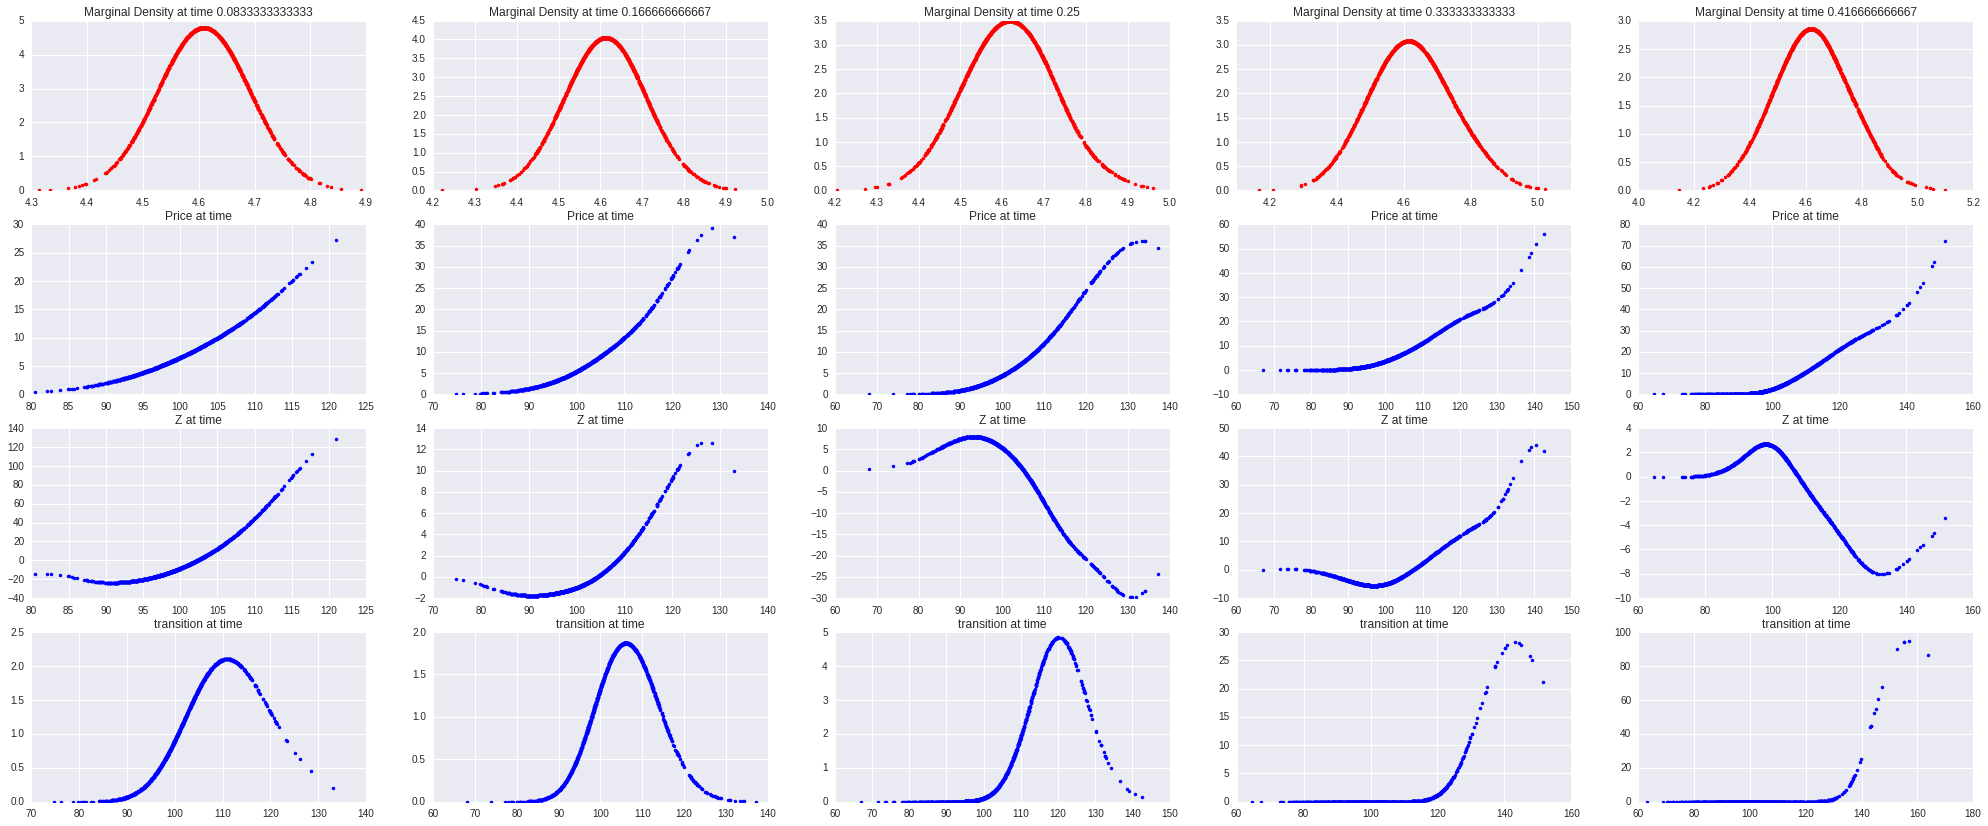

In [158]:
T = 0.5
m_time_discretization = 6
K = 100
S0 = 100
sigma = 0.2
r = 0.04


N_particles = 1000
mu = 0.06
R = 0.06
q = 0.
RF_n_trees = 100
RF_max_leaf_nodes = 50

test = BSDE(S0, K, T, mu, sigma, q)
#price_mesh_slow = test.get_price_mesh(N_particles, m_paths, r, R, mode='all neighbours')
#print("Mesh Slow = {}".format(price_mesh_slow))

plt.rcParams['figure.figsize'] = (7*m_time_discretization,7*2) # Make the figures a bit bigger
price_mesh_fast = test.get_price_mesh(N_particles, m_time_discretization, 
                                      r, R, mode='all neighbours', 
                                      n_picard = 5, 
                                      display_plot = True)
print("Mesh Fast = {}".format(price_mesh_fast))

price_LSM = test.get_price_lsm(R, r, N_particles, m_time_discretization, deg=5, n_picard = 10)
print("LSM = {}".format(price_LSM))


In [61]:
x = np.array([[1,2,3,45],[3,3,5,-1],[5,6,7,0]])
np.std(x, axis=1)


array([ 18.63296809,   2.17944947,   2.6925824 ])

In [70]:
def foo(AA):
    AA[1]=0
    B[1] = 1

A = np.array([1,2,3,4])
B = A.copy()
print(A)
foo(A)
print(A)

A[:] = 0
print(A)

[1 2 3 4]
[1 0 3 4]
[0 0 0 0]


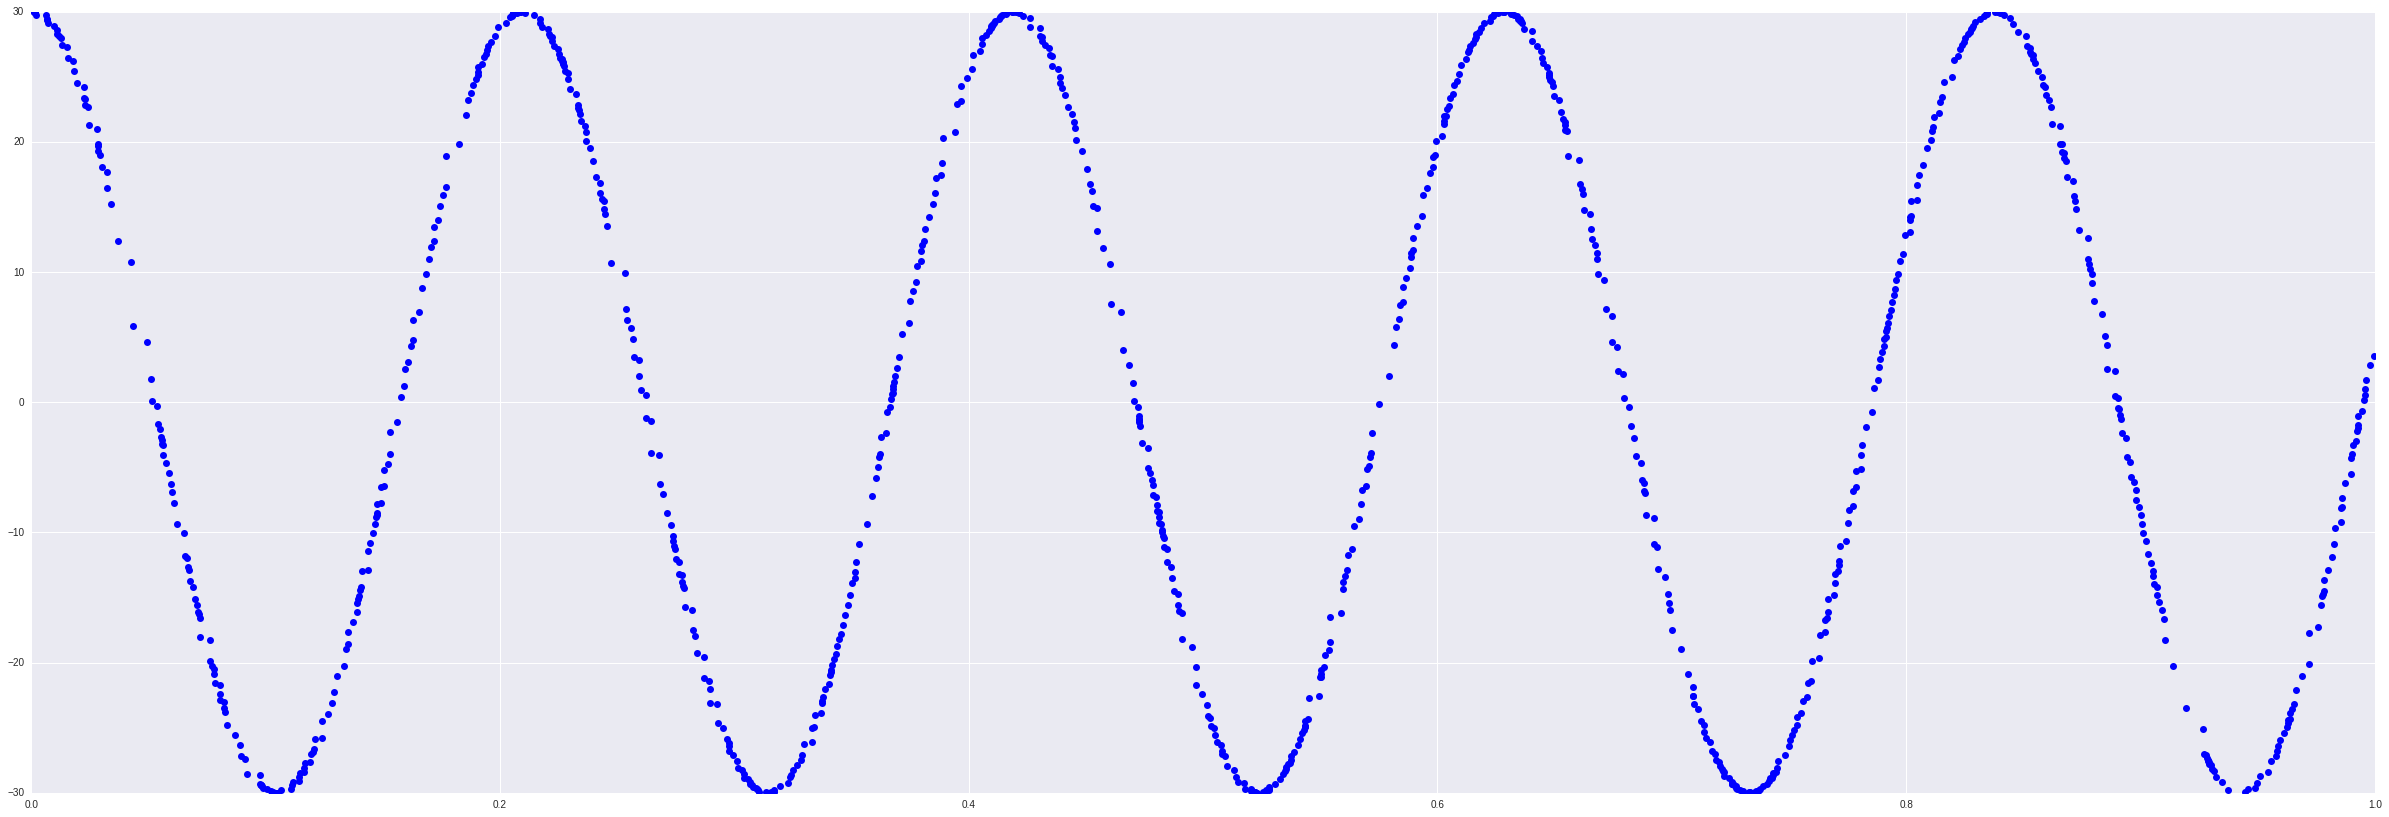

In [121]:
?np.gradient